# Preprocessing user-provided time series
*Developed by D. Brakenhoff, Artesia, and R.A. Collenteur, Eawag, January (2021-2023)*

This notebooks shows how to solve the most common errors that arise during the validation of the user provided time series. After showing how to deal with some of the easier errors, we will dive into the topic of making time series equidistant. For this purpose Pastas contains a lot of helper functions.   


In [1]:
import pastas as ps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ps.show_versions()

Python version: 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:09:13) [Clang 13.0.1 ]
NumPy version: 1.22.3
SciPy version: 1.9.3
Pandas version: 1.5.1
Pastas version: 0.22.0b0
Matplotlib version: 3.6.2


## 1. Validating the time series, what is checked?

Let us first look at the docstring of the `ps.validate_stress` method, which can be used to automatically check user-provided input time series. This method is also ud internally in Pastas to check all user provided time series. For the stresses `ps.validate_stress` is used and for the oseries the `ps.validate_oseries` is used. The only difference between these methods is that the oseries are not checked for equidistant time series.

In [11]:
ps.validate_stress?

Signature: ps.validate_stress(series: pandas.core.series.Series)
Docstring:
Method to validate user-provided stress input time series.

Parameters
----------
series: pandas.Series
    Pandas.Series object containing the series time series.

Notes
-----
The Series are validated for the following cases:

1. Make sure the values are floats
2. Make sure the index is a DatetimeIndex
3. Make sure the indices are datetime64
4. Make sure the index is monotonically increasing
5. Make sure there are no duplicate indices
6. Make sure the time series has no nan-values
7. Make sure the time series has equidistant time steps

If any of these checks are not passed the method will throw an error that needs
to be fixed by the user.

Examples
--------

>>> ps.validate_stress(series)
File:      ~/Github/pastas/pastas/pastas/timeseries.py
Type:      function


### a. If the time series is a DataFrame

In [ ]:
# Here's error message return by Pastas
ps.validate_stress(series)

In [ ]:
series.iloc[:,0]  # Simpy select the 

### b. If values are not floats

In [3]:
# Here's error message return by Pastas
ps.validate_stress(series)

In [ ]:
# Here is a possible fix to this issue
series = series.astype(float)

### c. If the index is not a datetimeindex

In [ ]:
# Here's error message return by Pastas
ps.validate_stress(series)

In [ ]:
# Here is a possible fix to this issue
series.index = pd.to_datetime(series.index)

### d. If index is not monotonically increasing

In [ ]:
# Here's error message return by Pastas
ps.validate_stress(series)

In [ ]:
# Here is a possible fix to this issue
series = series.sort_index()

### e. If the index has duplicate indices

In [ ]:
# Here's error message return by Pastas
ps.validate_stress(series)

In [ ]:
# Here is a possible fix to this issue
grouped = series.groupby(level=0)
series = grouped.mean()

### f. If the time series has nan-values

In [4]:
# Here's error message return by Pastas
ps.validate_stress(series)

ERROR: The frequency of the index of time series None could not be inferred. Please provide a time series with a regular time step.


ValueError: ('The frequency of the index of time series %s could not be inferred. Please provide a time series with a regular time step.', None)

In [3]:
# Here is a possible fix to this issue for oseries
series.dropna()                             # simply drop the nan-values

# Here is a possible fix to this issue for stresses
series = series.fillna(series.mean())       # For example for water levels
series.fillna(0.0)                          # For example for precipitation
series = series.interpolate(method="time")  # For example for evaporation

## 2. If a stress time series has non-equidistant time steps


In [ ]:
# Create timeseries
freq = "6H"
idx0 = pd.date_range("2000-01-01", freq=freq, periods=7).tolist()
idx0[0] = pd.Timestamp("2000-01-01 04:00:00")
idx0[-1] = pd.Timestamp("2000-01-02 11:00:00")
series = pd.Series(index=idx0, data=np.arange(len(idx0), dtype=float))

# Here's error message return by Pastas
ps.validate_stress(series)

In [ ]:
# Here is a possible fix to this issue


We define 3 pandas methods for resampling to an equidistant timeseries. 

1. The first takes a sample at equidistant timesteps from the original series, at the user-specified frequency.
2. The second creates a new equidistant index, rounded to the user-specified frequency. Then `Series.reindex()` is used with `method="nearest"`.
2. The third method rounds the series index down to the nearest user-specified frequency, then drops the duplicates before calling `Series.asfreq` with the user-specified frequency. This ensures no duplicates are in the resulting timeseries.

Pastas contains the function `pastas.utils.get_equidistant_timeseries()` which does something similar, but attempts to minimize the number of dropped points and ensures that each observation from the original timeseries is used only once in the resulting equidistant timeseries.


_**Note:** in terms of performance the pandas methods are undoubtedly faster._

In [6]:
def pandas_sample(series, freq):
    series = series.copy()
    t_offset = ps.utils._get_time_offset(series.index, freq).value_counts().idxmax()
    new_idx = pd.date_range(
        series.index[0].floor(freq) + t_offset,
        series.index[-1].floor(freq) + t_offset,
        freq=freq,
    )
    return series.reindex(new_idx)


def pandas_nearest(series, freq, tolerance=None):
    series = series.copy()
    # Create equidistant timeseries with Pandas
    idx = pd.date_range(
        series.index[0].floor(freq), series.index[-1].ceil(freq), freq=freq
    )
    spandas = series.reindex(idx, method="nearest", tolerance=tolerance)
    return spandas


def pandas_asfreq(series, freq):
    # Create equidistant timeseries with most frequent samples
    series = series.copy()
    series.index = series.index.floor(freq)
    spandas = (
        series.reset_index()
        .drop_duplicates(subset="index", keep="first", inplace=False)
        .set_index("index")
        .asfreq(freq)
        .squeeze()
    )
    return spandas

# Example 1

Lets create a timeseries spaced which is normally spaced with a frequency of 6 hours. The first and last measurement are shifted a bit later and earlier respectively. The two method compared here are the new function in Pastas and the Pandas reindex function.

/var/folders/hs/1j43d1k53k38dlwr99tmgf780000gn/T/ipykernel_31085/1973729731.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


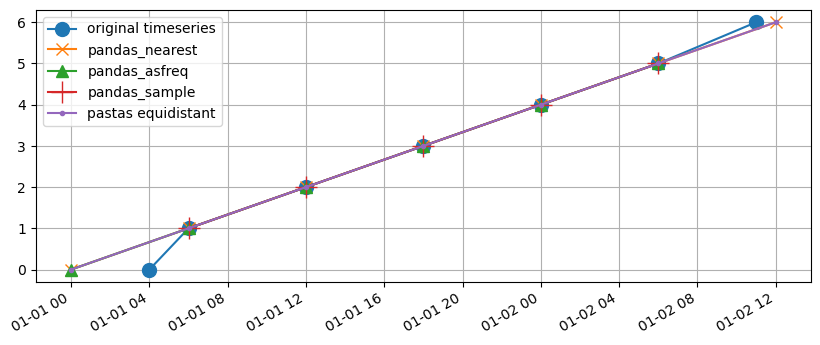

In [7]:
# Create timeseries
freq = "6H"
idx0 = pd.date_range("2000-01-01", freq=freq, periods=7).tolist()
idx0[0] = pd.Timestamp("2000-01-01 04:00:00")
idx0[-1] = pd.Timestamp("2000-01-02 11:00:00")
series = pd.Series(index=idx0, data=np.arange(len(idx0), dtype=float))

# Create equidistant timeseries with Pastas
s_pd1 = pandas_sample(series, freq)
s_pd2 = pandas_nearest(series, freq)
s_pd3 = pandas_asfreq(series, freq)
s_pastas = ps.utils.get_equidistant_series(series, freq)

# Create figure
plt.figure(figsize=(10, 4))
ax = series.plot(
    marker="o",
    label="original timeseries",
    ms=10,
)
s_pd2.plot(ax=ax, marker="x", ms=8, label="pandas_nearest")
s_pd3.plot(ax=ax, marker="^", ms=8, label="pandas_asfreq")
s_pd1.plot(ax=ax, marker="+", ms=16, label="pandas_sample")
s_pastas.plot(ax=ax, marker=".", label="pastas equidistant")
ax.grid(b=True)
ax.legend(loc="best")
ax.set_xlabel("");

As we can see, both the `pandas_nearest` and `pandas_asfreq` methods and `get_equidistant_series` show the expected behavior. The data at the beginning and at the end is shifted to the nearest equidistant timestamp. The `pandas_sample` method drops 2 datapoints because they're measured at different time offsets.

In [8]:
dfall = pd.concat([series, s_pd1, s_pd2, s_pd3, s_pastas], axis=1)
dfall.columns = [
    "original",
    "pandas_sample",
    "pandas_nearest",
    "pandas_asfreq",
    "pastas",
]
dfall

,original,pandas_sample,pandas_nearest,pandas_asfreq,pastas
2000-01-01 00:00:00,NaN,NaN,0.0,0.0,0.0
2000-01-01 04:00:00,0.0,NaN,NaN,NaN,NaN
2000-01-01 06:00:00,1.0,1.0,1.0,1.0,1.0
2000-01-01 12:00:00,2.0,2.0,2.0,2.0,2.0
2000-01-01 18:00:00,3.0,3.0,3.0,3.0,3.0
2000-01-02 00:00:00,4.0,4.0,4.0,4.0,4.0
2000-01-02 06:00:00,5.0,5.0,5.0,5.0,5.0
2000-01-02 11:00:00,6.0,NaN,NaN,NaN,NaN
2000-01-02 12:00:00,NaN,NaN,6.0,NaN,6.0


### Example 2

/var/folders/hs/1j43d1k53k38dlwr99tmgf780000gn/T/ipykernel_31085/3351234055.py:24: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


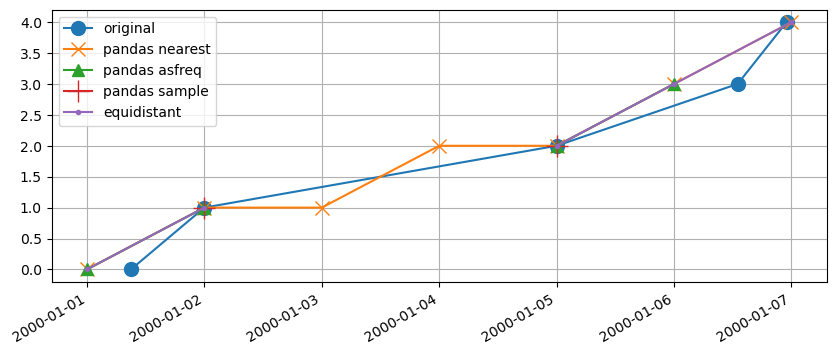

In [9]:
# Create timeseries
freq = "D"
idx0 = pd.date_range("2000-01-01", freq=freq, periods=7).tolist()
idx0[0] = pd.Timestamp("2000-01-01 09:00:00")
del idx0[2]
del idx0[2]
idx0[-2] = pd.Timestamp("2000-01-06 13:00:00")
idx0[-1] = pd.Timestamp("2000-01-06 23:00:00")
series = pd.Series(index=idx0, data=np.arange(len(idx0), dtype=float))

# Create equidistant timeseries
s_pd1 = pandas_sample(series, freq)
s_pd2 = pandas_nearest(series, freq)
s_pd3 = pandas_asfreq(series, freq)
s_pastas = ps.utils.get_equidistant_series(series, freq)

# Create figure
plt.figure(figsize=(10, 4))
ax = series.plot(marker="o", label="original", ms=10)
s_pd2.plot(ax=ax, marker="x", ms=10, label="pandas nearest")
s_pd3.plot(ax=ax, marker="^", ms=8, label="pandas asfreq")
s_pd1.plot(ax=ax, marker="+", ms=16, label="pandas sample")
s_pastas.plot(ax=ax, marker=".", label="equidistant")
ax.grid(b=True)
ax.legend(loc="best")
ax.set_xlabel("");

In this example, the shortcomings of `pandas_nearest` are clearly visible. It duplicates observations from the original timeseries to fill the gaps. This can be solved by passing e.g. `tolerance="0.99{freq}"` to `series.reindex()` in which case the gaps will not be filled. However, with very irregular timesteps this is not guaranteed to work and duplicates may still occur. The `pandas_asfreq` and pastas methods work as expected and use the available data to create a reasonable equidistant timeseries from the original data. The `pandas_sample` method is only able to keep two observations from the original series in this example.

In [10]:
dfall = pd.concat([series, s_pd1, s_pd2, s_pd3, s_pastas], axis=1)
dfall.columns = [
    "original",
    "pandas_sample",
    "pandas_nearest",
    "pandas_asfreq",
    "pastas",
]
dfall

,original,pandas_sample,pandas_nearest,pandas_asfreq,pastas
2000-01-01 00:00:00,NaN,NaN,0.0,0.0,0.0
2000-01-01 09:00:00,0.0,NaN,NaN,NaN,NaN
2000-01-02 00:00:00,1.0,1.0,1.0,1.0,1.0
2000-01-03 00:00:00,NaN,NaN,1.0,NaN,NaN
2000-01-04 00:00:00,NaN,NaN,2.0,NaN,NaN
2000-01-05 00:00:00,2.0,2.0,2.0,2.0,2.0
2000-01-06 00:00:00,NaN,NaN,3.0,3.0,3.0
2000-01-06 13:00:00,3.0,NaN,NaN,NaN,NaN
2000-01-06 23:00:00,4.0,NaN,NaN,NaN,NaN
2000-01-07 00:00:00,NaN,NaN,4.0,NaN,4.0


### Example 3

/var/folders/hs/1j43d1k53k38dlwr99tmgf780000gn/T/ipykernel_31085/2937533487.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


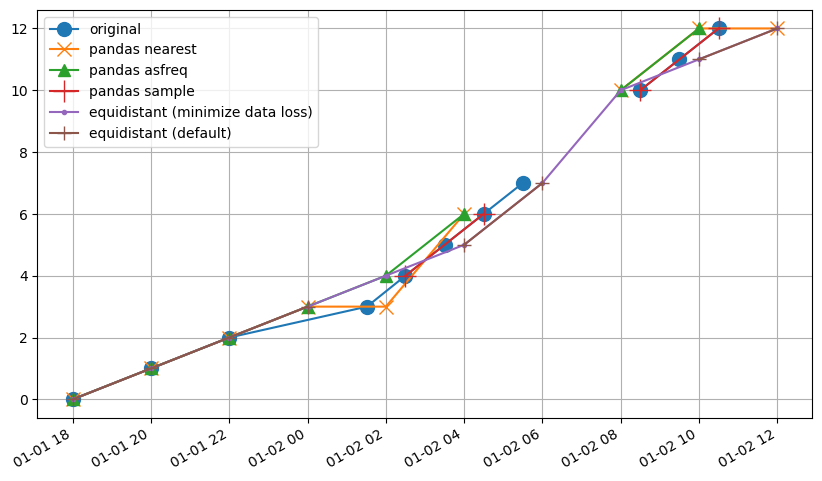

In [11]:
# Create timeseries
freq = "2H"
freq2 = "1H"
idx0 = pd.date_range("2000-01-01 18:00:00", freq=freq, periods=3).tolist()
idx1 = pd.date_range("2000-01-02 01:30:00", freq=freq2, periods=10).tolist()
idx0 = idx0 + idx1
idx0[3] = pd.Timestamp("2000-01-02 01:31:00")
series = pd.Series(index=idx0, data=np.arange(len(idx0), dtype=float))
series.iloc[8:10] = np.nan


# Create equidistant timeseries
s_pd1 = pandas_sample(series, freq)
s_pd2 = pandas_nearest(series, freq)
s_pd3 = pandas_asfreq(series, freq)
s_pastas1 = ps.utils.get_equidistant_series(series, freq, minimize_data_loss=True)
s_pastas2 = ps.utils.get_equidistant_series(series, freq, minimize_data_loss=False)


# Create figure
plt.figure(figsize=(10, 6))
ax = series.plot(marker="o", label="original", ms=10)
s_pd2.plot(ax=ax, marker="x", ms=10, label="pandas nearest")
s_pd3.plot(ax=ax, marker="^", ms=8, label="pandas asfreq")
s_pd1.plot(ax=ax, marker="+", ms=16, label="pandas sample")
s_pastas1.plot(ax=ax, marker=".", ms=6, label="equidistant (minimize data loss)")
s_pastas2.plot(ax=ax, marker="+", ms=10, label="equidistant (default)")
ax.grid(b=True)
ax.legend(loc="best")
ax.set_xlabel("");

In this example we can observe the following behavior in each method:
- `pandas_sample` retains 4 values.
- `pandas_nearest` duplicates some observations in the equidistant timeseries.
- `pandas_asfreq` does quite well, but drops some observations near the gap in the original timeseries.
- the pastas method with the default option misses an observation right after the gap in the original timeseries.
- the pastas method with `minimize_data_loss=True` fills this gap, using as much data as possible from the original timeseries.

The results from the `pandas_asfreq` and pastas method are both good, but the pastas methods retains more of the original data.

In [13]:
dfall = pd.concat([series, s_pd1, s_pd2, s_pd3, s_pastas2, s_pastas1], axis=1)
dfall.columns = [
    "original",
    "pandas_sample",
    "pandas_nearest",
    "pandas_asfreq",
    "pastas (default)",
    "pastas (minimize data loss)",
]
dfall

,original,pandas_sample,pandas_nearest,pandas_asfreq,pastas (default),pastas (minimize data loss)
2000-01-01 18:00:00,0.0,NaN,0.0,0.0,0.0,0.0
2000-01-01 18:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 20:00:00,1.0,NaN,1.0,1.0,1.0,1.0
2000-01-01 20:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 22:00:00,2.0,NaN,2.0,2.0,2.0,2.0
2000-01-01 22:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 00:00:00,NaN,NaN,3.0,3.0,3.0,3.0
2000-01-02 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 01:31:00,3.0,NaN,NaN,NaN,NaN,NaN
2000-01-02 02:00:00,NaN,NaN,3.0,4.0,NaN,4.0


### Example 4

/var/folders/hs/1j43d1k53k38dlwr99tmgf780000gn/T/ipykernel_31085/2962050219.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


Text(0.5, 0, '')

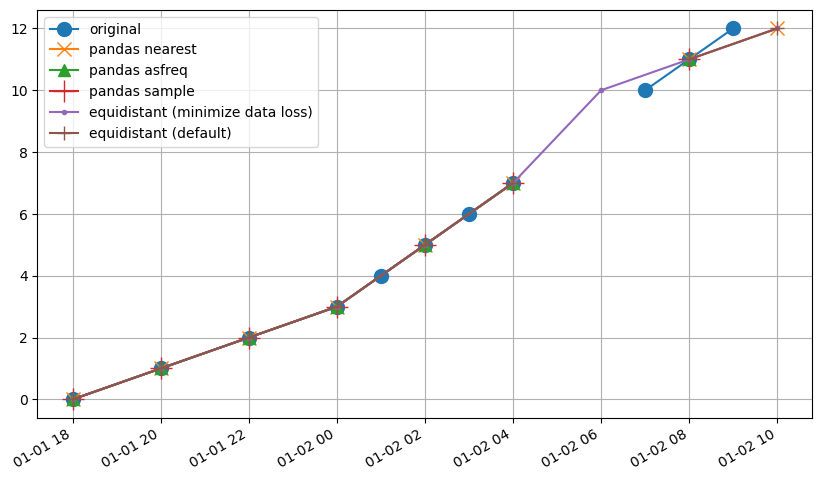

In [14]:
# Create timeseries
freq = "2H"
freq2 = "1H"
idx0 = pd.date_range("2000-01-01 18:00:00", freq=freq, periods=3).tolist()
idx1 = pd.date_range("2000-01-02 00:00:00", freq=freq2, periods=10).tolist()
idx0 = idx0 + idx1
series = pd.Series(index=idx0, data=np.arange(len(idx0), dtype=float))
series.iloc[8:10] = np.nan

# Create equidistant timeseries
s_pd1 = pandas_sample(series, freq)
s_pd2 = pandas_nearest(series, freq)
s_pd3 = pandas_asfreq(series, freq)
s_pastas1 = ps.utils.get_equidistant_series(series, freq, minimize_data_loss=True)
s_pastas2 = ps.utils.get_equidistant_series(series, freq, minimize_data_loss=False)

# Create figure
plt.figure(figsize=(10, 6))
ax = series.plot(marker="o", label="original", ms=10)
s_pd2.plot(ax=ax, marker="x", ms=10, label="pandas nearest")
s_pd3.plot(ax=ax, marker="^", ms=8, label="pandas asfreq")
s_pd1.plot(ax=ax, marker="+", ms=16, label="pandas sample")
s_pastas1.plot(ax=ax, marker=".", ms=6, label="equidistant (minimize data loss)")
s_pastas2.plot(ax=ax, marker="+", ms=10, label="equidistant (default)")
ax.grid(b=True)
ax.legend(loc="best")
ax.set_xlabel("")

Similar to the previous example, the pastas method retains the most data from the original timeseries. In this case both pandas methods perform well, but do omit some of the original data at the end of the timeseries or near the gap in the original timeseries.

In [15]:
dfall = pd.concat([series, s_pd1, s_pd2, s_pd3, s_pastas2, s_pastas1], axis=1)
dfall.columns = [
    "original",
    "pandas_sample",
    "pandas_nearest",
    "pandas_asfreq",
    "pastas (default)",
    "pastas (minimize data loss)",
]
dfall

,original,pandas_sample,pandas_nearest,pandas_asfreq,pastas (default),pastas (minimize data loss)
2000-01-01 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 20:00:00,1.0,1.0,1.0,1.0,1.0,1.0
2000-01-01 22:00:00,2.0,2.0,2.0,2.0,2.0,2.0
2000-01-02 00:00:00,3.0,3.0,3.0,3.0,3.0,3.0
2000-01-02 01:00:00,4.0,NaN,NaN,NaN,NaN,NaN
2000-01-02 02:00:00,5.0,5.0,5.0,5.0,5.0,5.0
2000-01-02 03:00:00,6.0,NaN,NaN,NaN,NaN,NaN
2000-01-02 04:00:00,7.0,7.0,7.0,7.0,7.0,7.0
2000-01-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 06:00:00,NaN,NaN,NaN,NaN,NaN,10.0
